In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

In [2]:
# Enlever tous les messages de prévention sous les résultats 
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [3]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

currencies

,date,dexalus,dexcaus,dexjpus,dexszus,dexukus
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [4]:
# Renommer colonnes
currencies.columns = ['date', 'Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
currencies

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [5]:
# Nettoyage + fréquence données 

currencies_daily = currencies.dropna()

print(f"Nombre observations avant nettoyage : {len(currencies)}")
print(f"Nombre observations après nettoyage : {len(currencies_daily)}")
print(f"Nombre observations supprimées : {len(currencies) - len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")
print(f"Durée totale : {(currencies_daily['date'].max() - currencies_daily['date'].min()).days} jours\n")

currencies_daily.info()

Nombre observations avant nettoyage : 5217
Nombre observations après nettoyage : 5011
Nombre observations supprimées : 206

Date de début : 2005-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

Durée totale : 7302 jours

<class 'pandas.core.frame.DataFrame'>
Index: 5011 entries, 0 to 5216
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5011 non-null   datetime64[ns]
 1   Australia    5011 non-null   float64       
 2   Canada       5011 non-null   float64       
 3   Japan        5011 non-null   float64       
 4   Switzerland  5011 non-null   float64       
 5   UK           5011 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 274.0 KB


In [6]:
currencies_daily

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5211,2024-12-24,1.605136,1.4383,157.29,0.9009,0.798212
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


### Justification du choix des données

**Pays d'origine** : USD (États-Unis)
- Toutes les paires de devises utilisent le dollar américain comme monnaie d'origine
- Ceci permet une analyse cohérente et facilite la comparaison entre devises

**Choix des 5 devises** :
1. **Brazil (BRL)** : Économie émergente d'Amérique du Sud, fortement influencée par les matières premières
2. **Canada (CAD)** : Économie développée, fortement liée aux États-Unis (commerce ALENA/ACEUM)
3. **Mexico (MXN)** : Économie émergente, également intégrée dans l'ACEUM
4. **UK (GBP)** : Économie européenne majeure, centre financier important (Brexit après 2016)
5. **EU (EUR)** : Zone euro, représentant la 2e plus grande économie mondiale

**Justification de la période** :
- Les données couvrent une période longue permettant de capturer différents cycles économiques
- Période suffisante pour analyser les relations macroéconomiques à basse fréquence
- Inclut des événements majeurs : crise de 2008, crise dette européenne, Brexit, COVID-19

**Fréquence** : 
- Les données brutes sont quotidiennes (jours ouvrables)
- Pour l'analyse factorielle, nous convertirons en fréquence **mensuelle** pour correspondre à la disponibilité des données macroéconomiques (PIB, inflation, taux d'intérêt, etc.)

## Conversion en fréquence mensuelle

In [14]:
# Recharger les données nettoyées pour éviter les problèmes de réexécution
currencies_temp = currencies.dropna().copy()

# Supprimer la colonne year temporaire si elle existe
if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir la date comme index
currencies_temp = currencies_temp.set_index('date')

# Rééchantillonner à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

# Supprimer les valeurs manquantes qui pourraient être créées
currencies_monthly = currencies_monthly.dropna()

print(f"Observations quotidiennes : {len(currencies_temp)}")
print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")
print(f"Nombre d'années : {(currencies_monthly.index.max() - currencies_monthly.index.min()).days / 365.25:.1f}")

currencies_monthly.info()

Observations quotidiennes : 5011
Observations mensuelles : 240
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00
Nombre d'années : 19.9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Australia    240 non-null    float64
 1   Canada       240 non-null    float64
 2   Japan        240 non-null    float64
 3   Switzerland  240 non-null    float64
 4   UK           240 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


## Calcul des rendements logarithmiques

Les rendements logarithmiques sont préférés pour l'analyse car :
- Ils sont additifs dans le temps
- Ils ont de meilleures propriétés statistiques
- Ils sont symétriques pour les hausses et baisses
- Formule : $r_t = \ln(S_t / S_{t-1}) = \ln(S_t) - \ln(S_{t-1})$

In [15]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()

# Convertir l'index en colonne pour faciliter les futures fusions
returns = returns.reset_index().rename(columns={'index': 'date'})

print(f"Nombre d'observations de rendements : {len(returns)}")
print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns[['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']].describe())

Nombre d'observations de rendements : 239

Statistiques descriptives des rendements mensuels :
        Australia      Canada       Japan  Switzerland          UK
count  239.000000  239.000000  239.000000   239.000000  239.000000
mean     0.000949    0.000627    0.001751    -0.001129    0.001712
std      0.035571    0.025482    0.027461     0.027786    0.025619
min     -0.088366   -0.085832   -0.075052    -0.130846   -0.087979
25%     -0.022536   -0.014970   -0.014262    -0.017888   -0.016751
50%      0.001297   -0.000443   -0.000246    -0.001204    0.001303
75%      0.021490    0.015222    0.019080     0.016745    0.016485
max      0.184246    0.137416    0.084550     0.118363    0.096575


In [16]:
returns

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-02-28,-0.023060,-0.008181,0.006737,-0.024893,-0.020946
1,2005-03-31,0.026934,-0.016483,0.028091,0.031187,0.018932
2,2005-04-30,-0.013494,0.038444,-0.024357,-0.004528,-0.012313
3,2005-05-31,0.031510,-0.004466,0.031328,0.045109,0.047716
4,2005-06-30,-0.003551,-0.020673,0.026866,0.030073,0.016648
...,...,...,...,...,...,...
234,2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487
235,2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128
236,2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369
237,2024-11-30,0.005665,0.005366,-0.012816,0.019921,0.012287


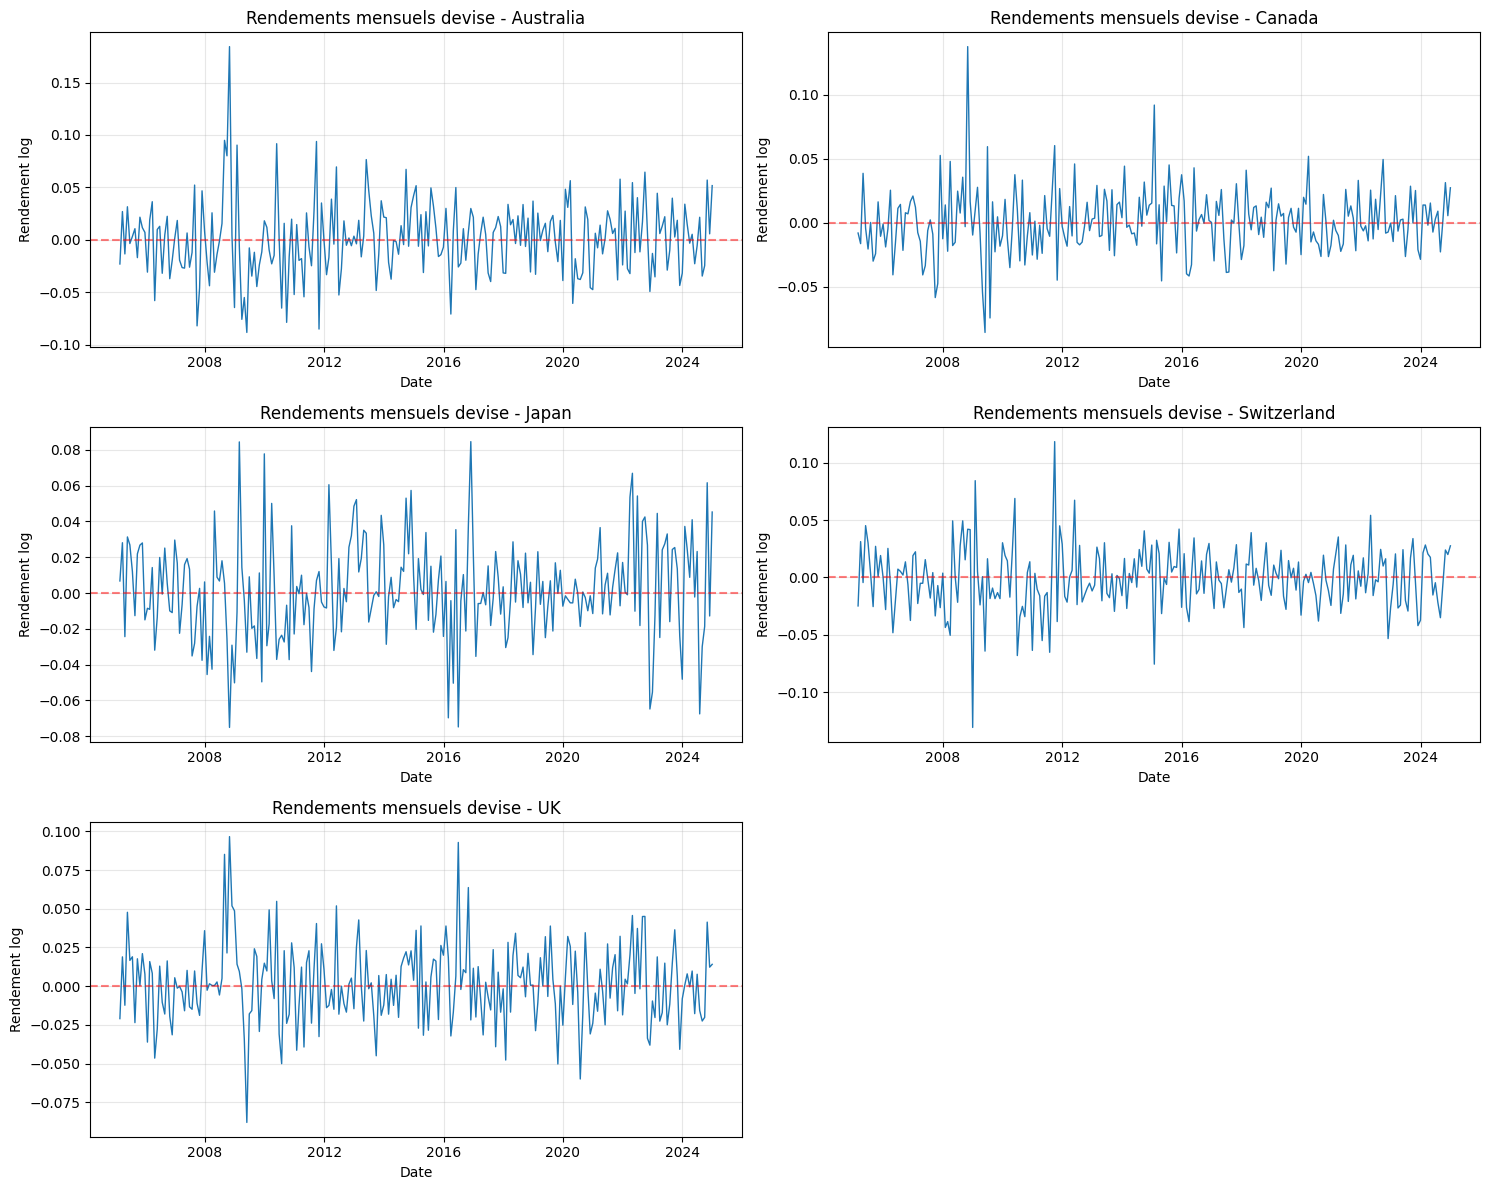

In [17]:
# Visualiser les rendements des 5 devises
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Liste des 5 devises (exclure la colonne 'date')
currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']

for i, col in enumerate(currencies_list):
    axes[i].plot(returns['date'], returns[col], linewidth=1)
    axes[i].set_title(f'Rendements mensuels devise - {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement log')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Masquer le dernier subplot (6ème)
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Analyse en Composantes Principales (ACP)

## Objectif
Effectuer une ACP sur les rendements des 5 devises pour identifier les facteurs communs qui expliquent les co-mouvements des devises.

## Méthodologie
L'ACP sera réalisée manuellement (sans utiliser sklearn.PCA) en suivant ces étapes :
1. Centrer les données (soustraire la moyenne)
2. Calculer la matrice de variance-covariance
3. Extraire les valeurs propres et vecteurs propres
4. Calculer les composantes principales
5. Analyser la variance expliquée

## Étape 1 : Préparation des données pour l'ACP

**Transformation requise** : Standardisation des données

La standardisation consiste à :

1. **Centrer** : Soustraire la moyenne de chaque variableCette étape met toutes les variables sur la même échelle (moyenne = 0, écart-type = 1), ce qui est équivalent à faire une ACP sur la **matrice de corrélation**.

2. **Réduire** : Diviser par l'écart-type de chaque variable

Formule : $Z = \frac{X - \mu}{\sigma}$

In [27]:
# Extraire uniquement les colonnes des rendements (sans 'date')
returns_matrix = returns[['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']].values

# Afficher les dimensions
print(f"Dimensions de la matrice des rendements : {returns_matrix.shape}")
print(f"  - {returns_matrix.shape[0]} observations (mois)")
print(f"  - {returns_matrix.shape[1]} variables (devises)")

# Standardiser les données : (X - moyenne) / écart-type
returns_mean = np.mean(returns_matrix, axis=0)
returns_std = np.std(returns_matrix, axis=0, ddof=1)  # ddof=1 pour écart-type non biaisé
returns_standardized = (returns_matrix - returns_mean) / returns_std

print(f"\n📊 Statistiques avant standardisation :")
for i, currency in enumerate(['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']):
    print(f"  {currency}: moyenne = {returns_mean[i]:.6f}, écart-type = {returns_std[i]:.6f}")

print(f"\n✅ Vérification de la standardisation :")
std_means = np.mean(returns_standardized, axis=0)
std_stds = np.std(returns_standardized, axis=0, ddof=1)

for i, currency in enumerate(['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']):    print(f"  {currency}: moyenne = {std_means[i]:.2e}, écart-type = {std_stds[i]:.4f}")

Dimensions de la matrice des rendements : (239, 5)
  - 239 observations (mois)
  - 5 variables (devises)

📊 Statistiques avant standardisation :
  Australia: moyenne = 0.000949, écart-type = 0.035571
  Canada: moyenne = 0.000627, écart-type = 0.025482
  Japan: moyenne = 0.001751, écart-type = 0.027461
  Switzerland: moyenne = -0.001129, écart-type = 0.027786
  UK: moyenne = 0.001712, écart-type = 0.025619

✅ Vérification de la standardisation :
  Australia: moyenne = 0.00e+00, écart-type = 1.0000
  Canada: moyenne = -7.43e-18, écart-type = 1.0000
  Japan: moyenne = -4.09e-17, écart-type = 1.0000
  Switzerland: moyenne = -1.49e-17, écart-type = 1.0000
  UK: moyenne = 5.57e-18, écart-type = 1.0000


## Étape 2 : Calcul de la matrice de corrélation

Sur des données standardisées, la matrice de variance-covariance devient la **matrice de corrélation**.

La matrice de corrélation capture les relations linéaires entre les devises, indépendamment de leurs échelles.

**Formule** : $R = \frac{1}{n-1} Z^T Z$ où $Z$ est la matrice standardisée

In [30]:
# Calculer la matrice de corrélation (covariance des données standardisées)
n = returns_standardized.shape[0]
corr_matrix = (returns_standardized.T @ returns_standardized) / (n - 1)

print("📊 Matrice de corrélation :")
print(pd.DataFrame(
    corr_matrix,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
).round(4))

# Vérification : la diagonale doit être ~1.0 (variance des données standardisées)
print(f"\n✅ Vérification : Diagonale de la matrice (doit être ≈ 1.0) :")
print(f"  {np.diag(corr_matrix)}")

📊 Matrice de corrélation :
             Australia  Canada   Japan  Switzerland      UK
Australia       1.0000  0.7442  0.1649       0.5881  0.5878
Canada          0.7442  1.0000  0.0704       0.3813  0.5541
Japan           0.1649  0.0704  1.0000       0.4115  0.1019
Switzerland     0.5881  0.3813  0.4115       1.0000  0.4835
UK              0.5878  0.5541  0.1019       0.4835  1.0000

✅ Vérification : Diagonale de la matrice (doit être ≈ 1.0) :
  [1. 1. 1. 1. 1.]


## Étape 3 : Extraction des valeurs propres et vecteurs propres

Les valeurs propres indiquent la variance expliquée par chaque composante principale.
Les vecteurs propres indiquent la direction (combinaison linéaire des devises) de chaque composante.

**Fonction autorisée** : `np.linalg.eig()` pour calculer eigenvalues et eigenvectors

In [31]:
# Calculer les valeurs propres et vecteurs propres de la matrice de corrélation
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# Trier par ordre décroissant des valeurs propres
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("📊 Valeurs propres (variance expliquée par chaque PC) :")
for i, val in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {val:.6f}")

print("\n📊 Vecteurs propres (loadings - poids de chaque devise dans les PCs) :")
loadings_df = pd.DataFrame(
    eigenvectors,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=[f'PC{i}' for i in range(1, 6)]
)
print(loadings_df.round(4))

📊 Valeurs propres (variance expliquée par chaque PC) :
  PC1: 2.757544
  PC2: 1.091808
  PC3: 0.509530
  PC4: 0.432553
  PC5: 0.208564

📊 Vecteurs propres (loadings - poids de chaque devise dans les PCs) :
                PC1     PC2     PC3     PC4     PC5
Australia   -0.5365 -0.1560  0.2550  0.2730 -0.7404
Canada      -0.4842 -0.3305  0.5613 -0.1072  0.5742
Japan       -0.2053  0.8381  0.3093 -0.3941 -0.0666
Switzerland -0.4622  0.3545 -0.4209  0.6071  0.3391
UK          -0.4711 -0.1958 -0.5891 -0.6246 -0.0506


## Étape 4 : Calcul des composantes principales

Les composantes principales sont les projections des données **standardisées** sur les vecteurs propres.

**Formule** : $PC = Z \times \text{Eigenvectors}$ où $Z$ est la matrice standardisée

In [32]:
# Calculer les composantes principales
principal_components = returns_standardized @ eigenvectors

# Créer un DataFrame avec les PCs
pc_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i}' for i in range(1, 6)]
)
pc_df.insert(0, 'date', returns['date'].values)

print(f"📊 Composantes principales calculées :")
print(f"  Dimensions : {principal_components.shape}")
print(f"\nAperçu des 5 premières observations :")
print(pc_df.head())

print(f"\nStatistiques descriptives des PCs :")
print(pc_df[[f'PC{i}' for i in range(1, 6)]].describe())

📊 Composantes principales calculées :
  Dimensions : (239, 5)

Aperçu des 5 premières observations :
        date       PC1       PC2       PC3       PC4       PC5
0 2005-02-28  1.304160  0.241623  0.570996 -0.185572  0.043933
1 2005-03-31 -1.117985  1.192639 -0.779512  0.179617 -0.629984
2 2005-04-30  0.008901 -1.160232  0.809472  0.372393  1.202394
3 2005-05-31 -2.200446  1.073174 -1.318314 -0.279849 -0.349261
4 2005-06-30 -0.508901  1.346459 -1.034749  0.012171 -0.095962

Statistiques descriptives des PCs :
                PC1           PC2           PC3           PC4           PC5
count  2.390000e+02  2.390000e+02  2.390000e+02  2.390000e+02  2.390000e+02
mean   2.229737e-17 -1.486491e-17 -2.229737e-17  1.091642e-17  1.521331e-17
std    1.660586e+00  1.044896e+00  7.138137e-01  6.576877e-01  4.566886e-01
min   -7.251470e+00 -5.096448e+00 -3.109112e+00 -3.693281e+00 -1.505506e+00
25%   -9.992429e-01 -5.365445e-01 -4.388786e-01 -3.643523e-01 -2.791522e-01
50%   -6.133406e-02  6.06646

## Étape 5 : Analyse de la variance expliquée

Calculer la proportion de variance totale expliquée par chaque composante principale.

In [33]:
# Calculer la variance expliquée (en proportion)
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Créer un tableau récapitulatif
variance_df = pd.DataFrame({
    'Composante': [f'PC{i}' for i in range(1, 6)],
    'Valeur propre': eigenvalues,
    'Variance expliquée (%)': explained_variance_ratio * 100,
    'Variance cumulée (%)': cumulative_variance * 100
})

print("📊 Tableau de variance expliquée :")
print(variance_df.round(2))

# Afficher un résumé
print(f"\n✅ Résumé :")
print(f"  - PC1 explique {explained_variance_ratio[0]*100:.2f}% de la variance")
print(f"  - PC1 + PC2 expliquent {cumulative_variance[1]*100:.2f}% de la variance")
print(f"  - PC1 + PC2 + PC3 expliquent {cumulative_variance[2]*100:.2f}% de la variance")

📊 Tableau de variance expliquée :
  Composante  Valeur propre  Variance expliquée (%)  Variance cumulée (%)
0        PC1           2.76                   55.15                 55.15
1        PC2           1.09                   21.84                 76.99
2        PC3           0.51                   10.19                 87.18
3        PC4           0.43                    8.65                 95.83
4        PC5           0.21                    4.17                100.00

✅ Résumé :
  - PC1 explique 55.15% de la variance
  - PC1 + PC2 expliquent 76.99% de la variance
  - PC1 + PC2 + PC3 expliquent 87.18% de la variance


## Étape 6 : Visualisations de l'ACP

### 6.1 Scree Plot (Graphique des valeurs propres)

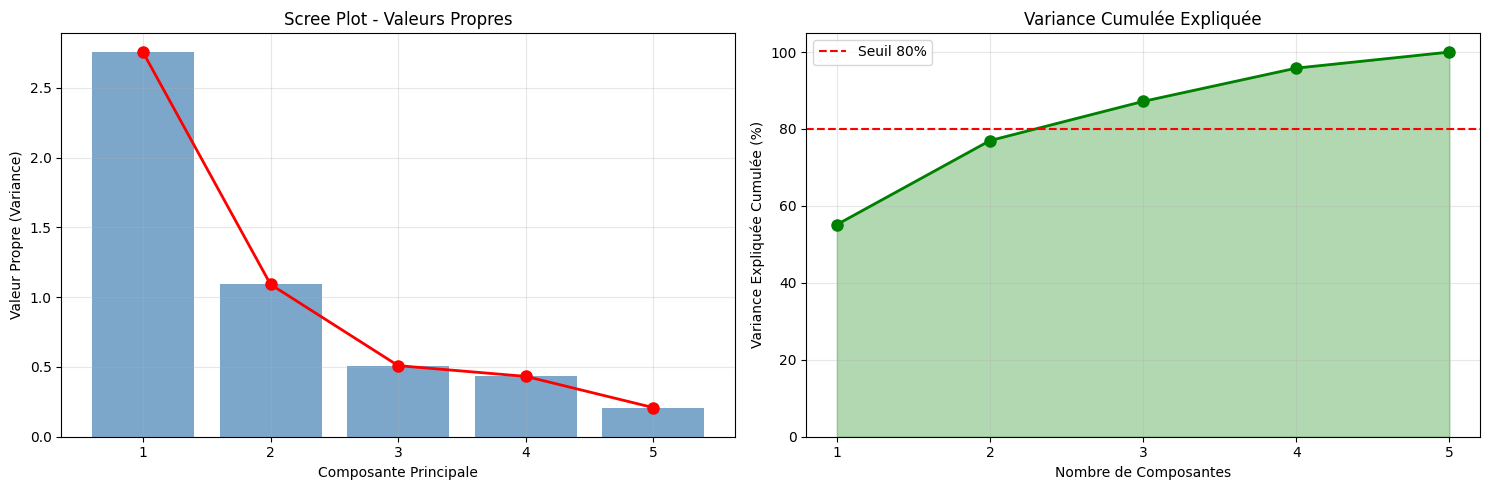

In [34]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique des valeurs propres
ax1.bar(range(1, 6), eigenvalues, alpha=0.7, color='steelblue')
ax1.plot(range(1, 6), eigenvalues, 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Composante Principale')
ax1.set_ylabel('Valeur Propre (Variance)')
ax1.set_title('Scree Plot - Valeurs Propres')
ax1.set_xticks(range(1, 6))
ax1.grid(True, alpha=0.3)

# Graphique de la variance cumulée
ax2.plot(range(1, 6), cumulative_variance * 100, 'go-', linewidth=2, markersize=8)
ax2.axhline(y=80, color='r', linestyle='--', label='Seuil 80%')
ax2.fill_between(range(1, 6), cumulative_variance * 100, alpha=0.3, color='green')
ax2.set_xlabel('Nombre de Composantes')
ax2.set_ylabel('Variance Expliquée Cumulée (%)')
ax2.set_title('Variance Cumulée Expliquée')
ax2.set_xticks(range(1, 6))
ax2.set_ylim([0, 105])
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### 6.2 Heatmap des Loadings (Poids des devises dans les PCs)

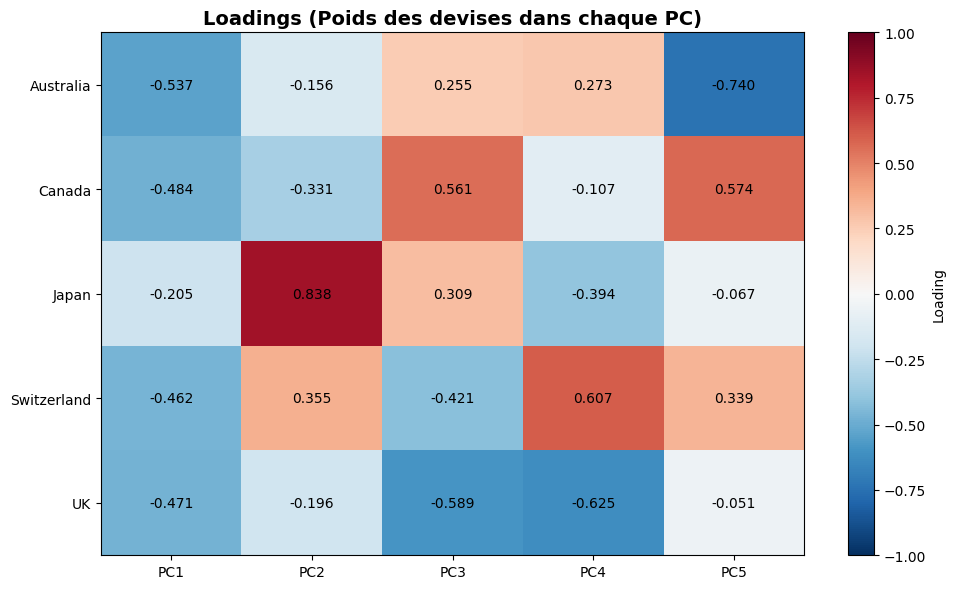

In [35]:
# Heatmap des loadings
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(eigenvectors, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Configuration des axes
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels([f'PC{i}' for i in range(1, 6)])
ax.set_yticklabels(['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'])

# Ajouter les valeurs dans chaque cellule
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, f'{eigenvectors[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10)

ax.set_title('Loadings (Poids des devises dans chaque PC)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Loading')
plt.tight_layout()
plt.show()

### 6.3 Évolution temporelle des Composantes Principales

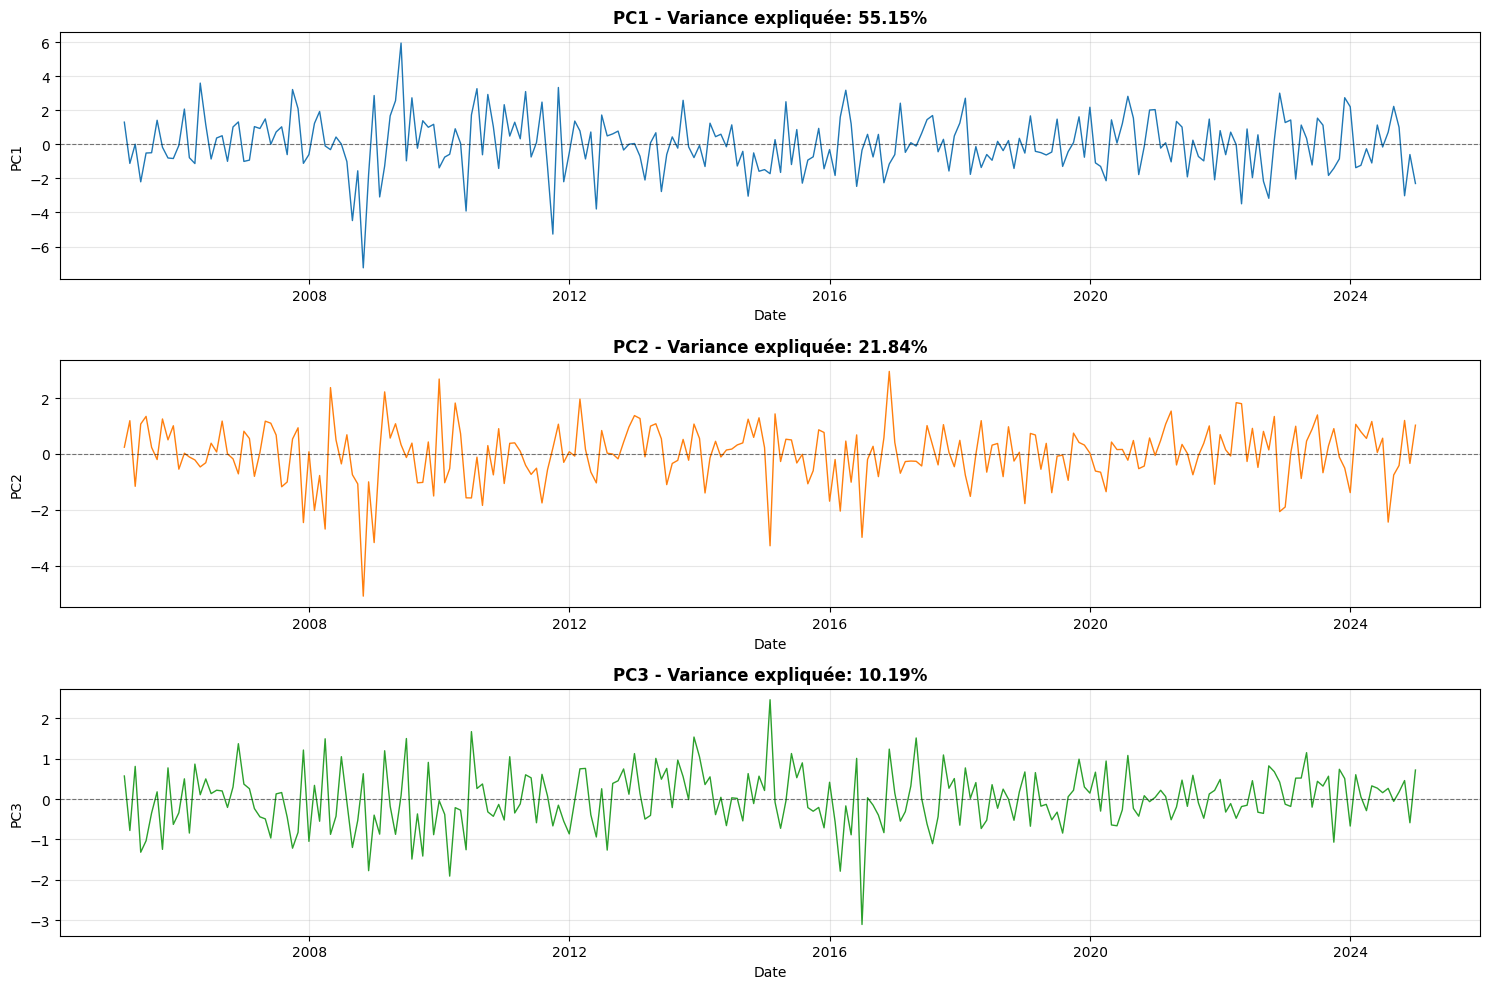

In [36]:
# Graphiques des 3 premières composantes principales
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i in range(3):
    axes[i].plot(pc_df['date'], pc_df[f'PC{i+1}'], linewidth=1, color=f'C{i}')
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[i].set_title(f'PC{i+1} - Variance expliquée: {explained_variance_ratio[i]*100:.2f}%', 
                     fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(f'PC{i+1}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Documentation des transformations effectuées

**Résumé des étapes de l'ACP** :

1. ✅ **Données d'entrée** : Matrice des rendements logarithmiques mensuels (239 × 5)
2. ✅ **Standardisation** : $(X - \mu) / \sigma$ pour chaque devise
   - Centrage : soustraction de la moyenne
   - Réduction : division par l'écart-type
3. ✅ **Matrice de corrélation** : Calcul de $R = \frac{1}{n-1} Z^T Z$ où $Z$ est standardisé
4. ✅ **Décomposition spectrale** : Extraction des valeurs/vecteurs propres via `np.linalg.eig()`
5. ✅ **Tri** : Classement par valeurs propres décroissantes
6. ✅ **Projection** : Calcul des PCs via $PC = Z \times \text{Eigenvectors}$

**Choix de la standardisation** :
- Met toutes les devises sur la même échelle (moyenne = 0, écart-type = 1)
- Équivalent à une ACP sur la **matrice de corrélation** plutôt que covariance
- Donne le même poids à chaque devise dans l'analyse
- Recommandé quand les variables ont des variances différentes